In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calc_a(a0, K, d, s, Emod):

    a = a0/np.sqrt(1+(K/Emod*d/s))

    return a


def piston_motion(lam, r, omega, t):
    v1 = omega * r * (np.sin(omega * t) + 0.5 * lam * np.sin(2 * omega * t))
    if ((omega * t) % (2 * np.pi)) < 1.0 * np.pi:
        v1 = 0
    #v2 = omega*r*(np.sin(np.pi*4/3 + omega*t)+0.5*lam*np.sin(2*(np.pi*4/3 + omega*t)))
    #if ((omega*t+ np.pi*4/3) % (2*np.pi)) < 1.0*np.pi:
    #    v2 = 0
    #v3 = omega*r*(np.sin(np.pi*2/3 + omega*t)+0.5*lam*np.sin(2*(np.pi*2/3 + omega*t)))
    #if ((omega*t + np.pi*2/3) % (2*np.pi)) < 1.0*np.pi:
    #    v3 = 0
    #v = v1 + v2 + v3

    return -v1

def pump(time):
    return -0.35 * np.minimum(np.sin(2.5 * time * 2.0 * np.pi), 0.0)

def vol_boundary(v_pist, A_piston):

    dV = v_pist

    return dV

def calc_re(v, nu, d):

    Re = np.abs(v)*d/nu

    return Re

def calc_J_steady(d, nu, v, roughness):
    #return 0.0

    Re = calc_re(v, nu, d)

    if Re == 0:
        f = 1
    elif Re > 0 and Re < 2100:

        f = 64/Re

    else:
        ff = 10

        err = 0.0001
        f_old = 0
        const = roughness / d * (1 / 3.7)

        while err > 1E-12:
            f = np.power(ff, 2)
            ff = 1/(-2*np.log10(const+2.51/(Re*np.sqrt(f))))
            err = np.abs(f-f_old)
            f_old = f

    J_s = f*v*np.abs(v)/(d*2)

    return J_s


def right_bc_v(pa, rho, a, vx, va, J, dt):

    px = pa - rho*a*(vx-va+J*dt)

    return px


def right_bc_p(va, rho, a, px, pa, J, dt):

    vx = va - 1/(rho*a)*(px-pa)-J*dt

    return vx


def left_bc_v(pb, rho, a, vx, vb, J, dt):

    px = pb + rho*a*(vx-vb+J*dt)

    return px


def left_bc_p(vb, rho, a, px, pb, J, dt):

    vx = vb + 1/(rho*a)*(px-pb) - J*dt

    return vx


def calc_px(va, vb, rho, a, pa, pb, dt, J_a, J_b):

    px = 0.5*(pa+pb+rho*a*(va-vb)-rho*a*dt*(J_a-J_b))

    return px


def calc_vx(pa, pb, rho, a, va, vb, dt, J_a, J_b):

    vx = 0.5*(va+vb+1/(rho*a)*(pa-pb)-dt*(J_a+J_b))

    return vx


def calc_brunone_c(Re):

    if Re < 2100:

        C = 0.00476
    else:
        b = np.power(Re, 0.05)
        d = 14.3/b
        x = np.log10(d)
        v = np.power(Re, x)
        C = 7.41/v

    k = np.sqrt(C)/2

    return k


def fric_unsteady_a(va, vat, dt, a, vx, dx, nu, d):
    return 0.0
    dvdt = (va-vat)/dt
    dvdx = (vx-va)/dx
    Re = calc_re(va, nu, d)
    k = calc_brunone_c(Re)
    J_a = k*(dvdt+a*np.sign(va*dvdx)*dvdx)
    
    return J_a


def fric_unsteady_b(vb, vbt, dt, a, vx, dx, nu, d):
    return 0.0
    dvdt = (vb-vbt)/dt
    dvdx = (vb-vx)/dx
    Re = calc_re(vb, nu, d)
    k = calc_brunone_c(Re)
    J_b = k*(dvdt+a*np.sign(vb*dvdx)*dvdx)

    return J_b


def calc_density(rho0, k, p, p0):
    rho = rho0 * np.exp((p - p0) / k)

    return rho


def calc_jres(Js, Ju):

    J = Js+Ju
    #J = 0.0

    return J

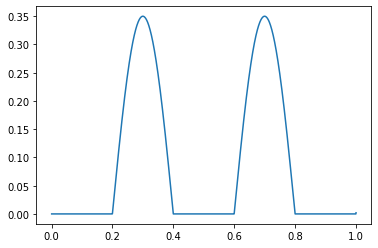

In [3]:
r = 0.045/2
omega = 150/60*np.pi*2
p0 = 101325
rho0 = 1000
g = 9.81
h0 = p0/(g*rho0)

diameter = 0.065
area = np.pi*diameter*diameter/4
length = 7
Emod = 2E11
K = 2.08E9
a0 = 1442.2205
s = 0.002
roughness = 0.0000001
visc = 1e-6


a = calc_a(a0, K, diameter, s, Emod)

lam = 0.01
n = 12
#dt = length/(2*n*a)
tmax = 1.0
dx = length/(n-1)
dt = dx / a


#t = np.linspace(0, tmax, int(tmax/dt))
t = np.arange(int(tmax/dt)+1) * dt

t = (1+np.arange(int(tmax/dt)+1)) * dt

v_bc = np.empty(t.shape[0])
v_piston = np.empty(t.shape[0])
v0 = np.empty(t.shape[0])
piston_diameter = 0.07
piston_area = piston_diameter*piston_diameter*np.pi/4

for i in range(t.shape[0]):
    #v_piston[i] = piston_motion(lam, r, omega, t[i])
    #v0[i] = vol_boundary(v_piston[i], piston_area)
    v0[i] = pump(t[i])
    #v0[i] = 0.35 * (t[i] > 0.25)

plt.plot(t, v0)
#plt.ylim((0,np.max(v0)))
plt.show()
v_bc = v0
v = np.zeros([t.shape[0], n])
p = np.zeros([t.shape[0], n])
fric = np.zeros([t.shape[0], n])
tre = np.zeros([t.shape[0], n])
vs = np.zeros(t.shape[0])
ps = np.zeros(t.shape[0])
vbc = 0
rho = rho0
vbeh = np.zeros(t.shape[0])
vbeh1 = np.zeros(t.shape[0])
vbeh2 = np.zeros(t.shape[0])
pbeh1 = np.zeros(t.shape[0])
tank_area = 1.5*1.5*np.pi/4
pkopp = np.zeros(t.shape[0])
pbeh = p0

In [4]:
print(dt)
print(dx)
print(a)
print(t.shape)

0.0005103895186696741
0.6363636363636364
1246.8195624830084
(1960,)


In [5]:
for i in range(t.shape[0]):


    for j in range(n):

        if i == 0:

            p[i, j] = 101325
            pbeh1[i] = 101325
            pkopp[i] = 101325
            v[i, j] = 0
            vbeh[i] = 0
            vbeh1[i] = 0
            vbeh2[i] = 0

        else:
            if j == 0:

                #rho = calc_density(rho0, K, p0, p[i-1, j])
                Js = calc_J_steady(diameter, visc, v[i-1, j+1], roughness)
                Jbeh = calc_J_steady(2, visc, vbeh[i-1], roughness)

                Jbeh1 = calc_J_steady(2, visc, vbeh1[i - 1], roughness)
                Jbeh2 = calc_J_steady(2, visc, vbeh2[i - 1], roughness)

                pbeh = p0
                vbeh[i] = left_bc_p(vbeh1[i - 1], rho, a, pbeh, pbeh1[i - 1], Jbeh1, dt)
                vbeh1[i] = calc_vx(pbeh, pkopp[i - 1], rho, a, vbeh[i - 1], vbeh2[i - 1], dt, Jbeh, Jbeh2)
                pbeh1[i] = calc_px(vbeh[i - 1], vbeh2[i - 1], rho, a, pbeh, pkopp[i - 1], dt, Jbeh, Jbeh2)
                verh = area/tank_area
                pkopp[i] = (rho*a*(vbeh1[i-1]-verh*v[i-1, j+1])+p[i-1, j+1]*verh+pbeh1[i-1]-rho*a*(Jbeh1+verh*Js)*dt)/(verh+1)
                #pkopp[i] = rho*a/2*(vbeh1[i-1]-area/area*v[i-1, j+1]-(Jbeh1+Js)*dt+pbeh1[i-1]+p[i-1, j+1])
                vbeh2[i] = right_bc_p(vbeh1[i-1], rho, a, pkopp[i], pbeh1[i-1], Jbeh1, dt)
                

                if i == 1:
                    Ju = 0
                else:
                    Ju = fric_unsteady_b(v[i-1, j+1], v[i-2, j+1], dt, a, v[i-1, j], dx, visc, diameter)

                J = calc_jres(Js, Ju)
                #p[i, j] = pkopp[i]
                tre [i,j] = calc_re(v[i-1,j], visc, diameter)
                p[i,j] = p0
                #p[i, j] = left_bc_v(p[i - 1, j + 1], rho, a, v[i, j], v[i - 1, j + 1], J, dt)
                #p[i, j] = p0
                v[i, j] = left_bc_p(v[i-1, j+1], rho, a, p[i, j], p[i-1, j+1], J, dt)


            elif j == n-1:
                #rho = calc_density(rho0, K, p0, p[i-1, j])
                Js = calc_J_steady(diameter, visc, v[i-1, j-1], roughness)

                if i == 1:
                    Ju = 0
                else:
                    Ju = fric_unsteady_a(v[i-1, j-1], v[i-2, j-1], dt, a, v[i-1, j], dx, visc, diameter)

                tre [i,j] = calc_re(v[i-1,j], visc, diameter)
                J = calc_jres(Js, Ju)
                v[i, j] = v0[i]
                p[i, j] = right_bc_v(p[i-1, j-1], rho, a, v[i, j], v[i-1, j-1], J, dt)

            else:
                #rho = calc_density(rho0, K, p0, p[i-1, j])
                if i == 1:
                    Jua = 0
                    Jub = 0

                else:
                    Jua = fric_unsteady_a(v[i-1, j-1], v[i-2, j-1], dt, a, v[i-1, j], dx, visc, diameter)
                    Jub = fric_unsteady_b(v[i-1, j+1], v[i-2, j+1], dt, a, v[i-1, j], dx, visc, diameter)


                Jsa = calc_J_steady(diameter, visc, v[i-1, j-1], roughness)
                Jsb = calc_J_steady(diameter, visc, v[i-1, j+1], roughness)

                tre [i,j] = calc_re(v[i-1,j], visc, diameter)
                fric[i, j-1] = Jsa
                fric[i, j+1] = Jsb
                Ja = calc_jres(Jsa, Jua)
                Jb = calc_jres(Jsb, Jub)

                v[i, j] = calc_vx(p[i-1, j-1], p[i-1, j+1], rho, a, v[i-1, j-1], v[i-1, j+1], dt, Ja, Jb)
                p[i, j] = calc_px(v[i-1, j-1], v[i-1, j+1], rho, a, p[i-1, j-1], p[i-1, j+1], dt, Ja, Jb)

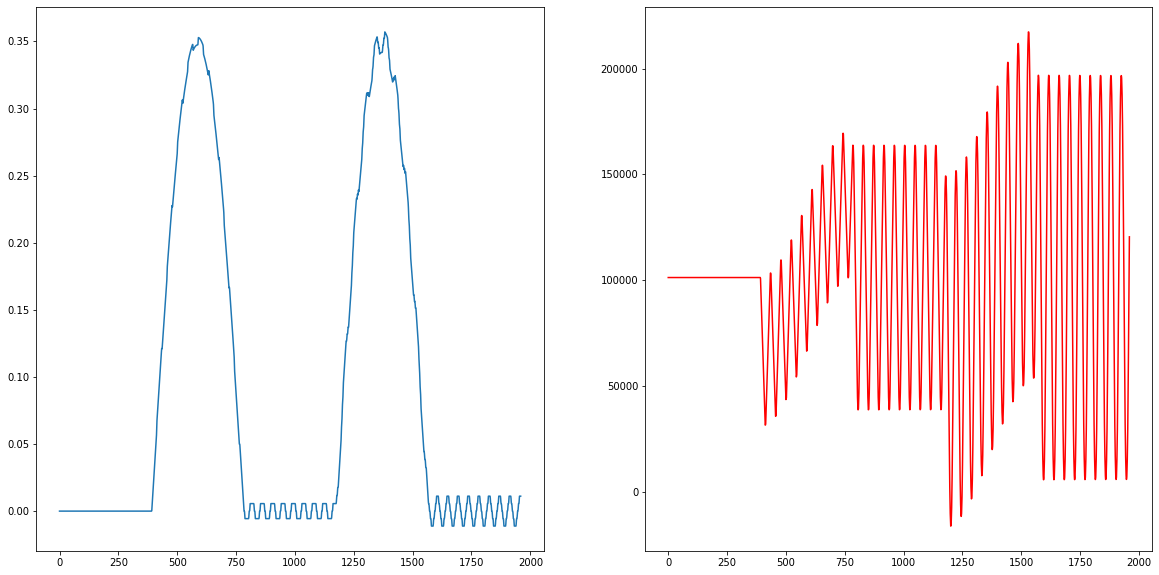

In [6]:
plt.figure(figsize=(20, 10))
val = -2
plt.subplot(1, 2, 1)
plt.plot(v[0:, val], label='Durchfluss')
plt.subplot(1, 2, 2)
plt.plot(p[:, val], label='Förderhöhe', color='red')
#plt.plot(t[0:],vbeh1[0:])
#plt.plot(t[275:], p[275:, 0], label='Förderhöhe', color='blue')
#plt.ylim((118000, 1.01*np.max(p[val, :])))
#plt.ylim((np.min(pbeh1[0:]),0.000001))
#plt.legend(loc = 'upper right')
#plt.subplot(2,1,1)
#plt.plot(t,vs)
plt.show()

In [7]:
np.save('../../../pressure_fe.npy', p[:, val])
np.save('../../../velocity_fe.npy', v[0:, val])
np.save('../../../last_pressure_fe.npy', p[-1, :])
np.save('../../../last_velocity_fe.npy', v[-1, :])

In [8]:
print(p[:,val].shape)

(1960,)


In [9]:
print(t[-1])

1.0003634565925612


In [10]:
Re = [calc_re(v[-1,i], visc, diameter) for i in range(v.shape[1])]

In [11]:
for _ in Re:
    print(_)

4961.663148895808
4910.117447486761
4729.425883160853
4548.312604624918
4263.607340205194
3875.853780067154
3334.6027777440036
2792.8926903781617
2172.5626628497907
1448.4701860883793
724.1570233160601
129.88274824310793


In [12]:
Js = [calc_J_steady(diameter, visc, v[-1,i], roughness) for i in range(v.shape[1])]

In [13]:
for _ in Js: print(1000*_)

1.679783828131211
1.6500191036218956
1.5474842515140936
1.447546017932804
1.2962466674976114
1.1017619915301828
0.8531402812638437
0.6318418278947974
0.41379877496404016
0.1687794117608671
0.08438060899813897
0.015134266522637963


In [14]:
for _ in v[-1,:]: print(_)

0.07633327921378166
0.07554026842287324
0.07276039820247467
0.06997404007115257
0.06559395908007991
0.05962851969334082
0.05130158119606159
0.042967579851971714
0.03342404096691985
0.022284156709051987
0.011140877281785538
0.0019981961268170445


In [15]:
print(t[-1])

1.0003634565925612


In [16]:
print(t.shape)

(1960,)


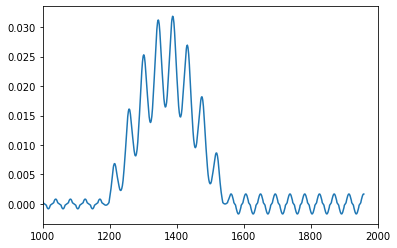

In [17]:
plt.plot(fric[:,1])
plt.xlim(1000,2000)
plt.show()